**Mount to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
from sklearn.model_selection import train_test_split
from tqdm import tqdm

1. Load the dataset

In [ ]:
# Legitimate URL Dataset
legit_df = pd.read_csv('/content/drive/MyDrive/Thesis - Undergraduate Ch./Dataset/Legitimate/Filtered/filtered_legitimate_url_10000_again.csv')
# Phishing URL Dataset')
phish_df = pd.read_csv('/content/drive/MyDrive/Thesis - Undergraduate Ch./Dataset/Phishing/Cleaned/combined_phishing_url_5000.csv')

# Display samples
print(legit_df.head())
print(phish_df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Thesis - Undergraduate Ch./Dataset/Phishing/Cleaned/combined_phishing_url_5000.csv'

2. Preprocessing Parameters

In [ ]:
# Create combined unique character set
combined_urls = legit_df['Legitimate_URL'].tolist() + phish_df['Phishing_URL'].tolist()
all_chars = sorted(set(''.join(combined_urls)))
print("Unique chars:", all_chars)

# Character to index mapping (+1 for padding 0)
char_to_idx = {ch: idx+1 for idx, ch in enumerate(all_chars)}

# Vocabulary size (+1 for padding)
vocab_size = len(char_to_idx) + 1
max_len = 100

print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum URL Length: {max_len}")

# Save char_to_idx to JSON file
with open('/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/vocabulary_again.json', 'w') as f:
    json.dump(char_to_idx, f)

Unique chars: ['!', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '~']
Vocabulary Size: 82
Maximum URL Length: 100


3. One-hot Encoding & Tensor Conversion Function

In [ ]:
def encode_url(url, max_len):
    """
    One-hot encode a URL at character-level, pad/truncate to max_len.
    """
    encoded = np.zeros((max_len, vocab_size), dtype=np.float32) # padding

    for i, ch in enumerate(url[:max_len]): # tokenization
        if ch in char_to_idx:
            encoded[i, char_to_idx[ch]] = 1.0 # character-level encoding

    return encoded

4. Split the data

In [ ]:
# Number of legitimate URLs
n_legit = len(legit_df)

# Training: 70% legitimate
train_legit = legit_df.sample(n=8000, random_state=42)
test_legit  = legit_df.drop(train_legit.index)

# All phishing for test
test_phish = phish_df

# Combine test set: 30% legitimate + phishing
test_df = pd.concat([test_legit.iloc[:1000], test_phish.iloc[:1000]], ignore_index=True)

print(f"Training Legitimate: {len(train_legit)}")
print(f"Testing Legitimate: {len(test_legit.iloc[:1000])}")
print(f"Testing Phishing: {len(test_phish.iloc[:1000])}")

Training Legitimate: 8000
Testing Legitimate: 1000
Testing Phishing: 1000


5. Preprocess training data

In [ ]:
X_train = []
y_train = []

for _, row in tqdm(train_legit.iterrows(), total=train_legit.shape[0]):
    one_hot_url = encode_url(row['Legitimate_URL'], max_len)
    X_train.append(one_hot_url)
    y_train.append(0)  # label 0 for legitimate

X_train = np.stack(X_train)
X_train = X_train[:, np.newaxis, :, :]  # (N, 1, H, W)

# Convert to torch tensor
X_train_tensor = torch.tensor(X_train)
print(X_train_tensor.shape)

100%|██████████| 8000/8000 [00:00<00:00, 8507.93it/s]


torch.Size([8000, 1, 100, 82])


6. Preprocess testing Data

In [ ]:
X_test = []
y_test = []

for _, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    # Detect if row is phishing or legit and handle missing values
    if 'Legitimate_URL' in row and isinstance(row['Legitimate_URL'], str):  # Check if the URL is a string
        url = row['Legitimate_URL']
        label = 0
    elif 'Phishing_URL' in row and isinstance(row['Phishing_URL'], str):  # Check if the URL is a string
        url = row['Phishing_URL']
        label = 1
    else:
        continue  # Skip rows with missing or non-string URLs

    one_hot_url = encode_url(url, max_len)
    X_test.append(one_hot_url)
    y_test.append(label)

X_test = np.stack(X_test)
X_test = X_test[:, np.newaxis, :, :]

# Convert to torch tensors
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

print(X_test_tensor.shape, y_test_tensor.shape)

100%|██████████| 2000/2000 [00:00<00:00, 12576.38it/s]


torch.Size([2000, 1, 100, 82]) torch.Size([2000])


7. Print the output shape for each data

In [ ]:
print(f"X_train shape: {X_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")

X_train shape: torch.Size([8000, 1, 100, 82])
X_test shape: torch.Size([2000, 1, 100, 82])
y_test shape: torch.Size([2000])


7. Saved Preprocessed Tensors

In [ ]:
torch.save(X_train_tensor, '/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_train_8000_tensor.pt')
torch.save(X_test_tensor, '/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/X_test_1000_tensor.pt')
torch.save(y_test_tensor, '/content/drive/MyDrive/Thesis - Undergraduate Ch./Preprocessing/y_test_1000_tensor.pt')

print("Preprocessed tensors saved successfully!")

Preprocessed tensors saved successfully!


[Additional] PCA Analysis

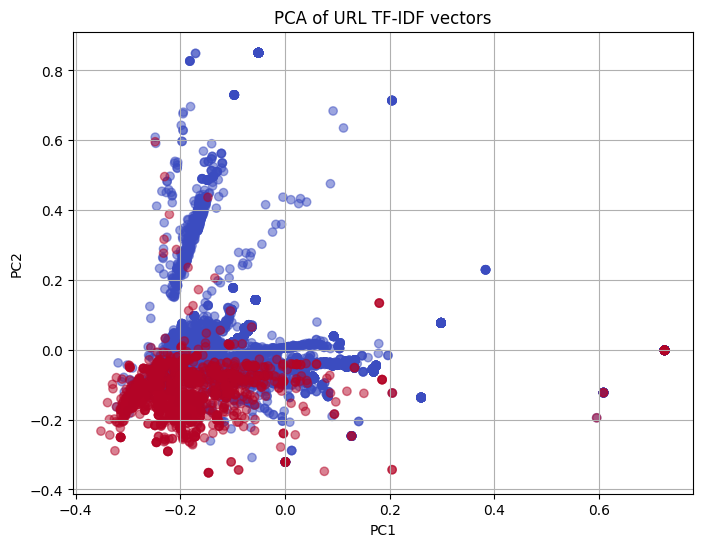

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already imported

# Assuming 'legit_df' and 'phish_df' are your DataFrames:

# 1. Add 'label' column to each DataFrame
legit_df['label'] = 'legitimate'
phish_df['label'] = 'phishing'

# 2. Rename the URL column to 'url' in both DataFrames
legit_df = legit_df.rename(columns={'Legitimate_URL': 'url'})
phish_df = phish_df.rename(columns={'Phishing_URL': 'url'})

# 3. Concatenate the two DataFrames
df = pd.concat([legit_df[['url', 'label']], phish_df[['url', 'label']]], ignore_index=True)

# 4. Proceed with TF-IDF and PCA
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['url'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 5. Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['label'].map({'legitimate': 0, 'phishing': 1}), cmap='coolwarm', alpha=0.5)
plt.title('PCA of URL TF-IDF vectors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()